### FOR TRAIN SPLIT OF ONLY 2K

In [ ]:
import tensorflow_datasets as tfds
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Loading
(train_data, test_data), ds_info = tfds.load(
    'mnist_corrupted/identity',
    split=['train[:2000]', 'test[:2000]'],
    as_supervised=True,
    with_info=True
)


def convert_to_numpy(dataset):
    return np.array([img.numpy() for img, _ in dataset])

train_images = convert_to_numpy(train_data)
test_images = convert_to_numpy(test_data)


train_images = torch.Tensor(train_images / 255.0).unsqueeze(1).squeeze(-1)
test_images = torch.Tensor(test_images / 255.0).unsqueeze(1).squeeze(-1)

# Create DataLoader
batch_size = 128
train_dataset = TensorDataset(train_images)
test_dataset = TensorDataset(test_images)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training set size: {len(train_images)}")
print(f"Test set size (identity): {len(test_images)}")

Training set size: 2000
Test set size (identity): 2000


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=True),
            nn.BatchNorm2d(ngf * 4),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 3, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 2),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf),
            nn.ELU(),
            nn.ConvTranspose2d(ngf, 1, 4, 2, 1, bias=True),
            nn.Tanh()
        )

    def forward(self, x):
        return self.network(x)

# Initialization
nz = 100
ngf = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Generator().to(device)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 30
training_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_images, in train_loader:
        batch_images = batch_images.to(device)
        current_batch_size = batch_images.size(0)

        optimizer.zero_grad()

        # Gradient origin optimization
        z = torch.zeros(current_batch_size, nz, 1, 1, device=device, requires_grad=True)
        g = model(z)
        L_inner = ((g - batch_images) ** 2).sum(1).mean()
        grad = torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]
        z = -grad

        # Optimizing data fitting loss
        g = model(z)
        L_outer = ((g - batch_images) ** 2).sum(1).mean()
        L_outer.backward()
        optimizer.step()

        epoch_loss += L_outer.item() * current_batch_size

    average_epoch_loss = epoch_loss / len(train_loader.dataset)
    training_losses.append(average_epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_epoch_loss:.4f}')

Epoch [1/30], Loss: 0.4764
Epoch [2/30], Loss: 0.2536
Epoch [3/30], Loss: 0.2002
Epoch [4/30], Loss: 0.1543
Epoch [5/30], Loss: 0.1212
Epoch [6/30], Loss: 0.0868
Epoch [7/30], Loss: 0.0732
Epoch [8/30], Loss: 0.0633
Epoch [9/30], Loss: 0.0556
Epoch [10/30], Loss: 0.0491
Epoch [11/30], Loss: 0.0439
Epoch [12/30], Loss: 0.0372
Epoch [13/30], Loss: 0.0344
Epoch [14/30], Loss: 0.0335
Epoch [15/30], Loss: 0.0317
Epoch [16/30], Loss: 0.0313
Epoch [17/30], Loss: 0.0302
Epoch [18/30], Loss: 0.0264
Epoch [19/30], Loss: 0.0247
Epoch [20/30], Loss: 0.0237
Epoch [21/30], Loss: 0.0225
Epoch [22/30], Loss: 0.0219
Epoch [23/30], Loss: 0.0212
Epoch [24/30], Loss: 0.0206
Epoch [25/30], Loss: 0.0206
Epoch [26/30], Loss: 0.0203
Epoch [27/30], Loss: 0.0192
Epoch [28/30], Loss: 0.0186
Epoch [29/30], Loss: 0.0182
Epoch [30/30], Loss: 0.0177


In [ ]:
# Computation of reconstruction errors
def reconstruction_loss(model, loader):
    model.eval()
    error_list = []
    with torch.no_grad():
        for batch_images, in loader:
            batch_images = batch_images.to(device)
            current_batch_size = batch_images.size(0)
            z = torch.zeros(current_batch_size, nz, 1, 1, device=device)
            generated_images = model(z)
            loss = torch.mean((generated_images - batch_images) ** 2, dim=[1, 2, 3])
            error_list.extend(loss.cpu().numpy())
    return np.array(error_list)

training_reconstruction_errors = reconstruction_loss(model, train_loader)

# Calculation of dynamic threshold
def dynamic_threshold(errors):
    return np.mean(errors) + 2 * np.std(errors)

# Setting the anomaly detection threshold
threshold = dynamic_threshold(training_reconstruction_errors)
print(f"Initial anomaly detection threshold: {threshold}")

Initial anomaly detection threshold: 0.1446748822927475


Evaluating corruption type: identity
Number of images in the identity test set: 2000
Evaluating corruption type: shot_noise
Number of images in the shot_noise test set: 2000
Evaluating corruption type: impulse_noise
Number of images in the impulse_noise test set: 2000
Evaluating corruption type: glass_blur
Number of images in the glass_blur test set: 2000
Evaluating corruption type: motion_blur
Number of images in the motion_blur test set: 2000
Evaluating corruption type: shear
Number of images in the shear test set: 2000
Evaluating corruption type: scale
Number of images in the scale test set: 2000
Evaluating corruption type: rotate
Number of images in the rotate test set: 2000
Evaluating corruption type: brightness
Number of images in the brightness test set: 2000
Evaluating corruption type: translate
Number of images in the translate test set: 2000
Evaluating corruption type: stripe
Number of images in the stripe test set: 2000
Evaluating corruption type: fog
Number of images in the

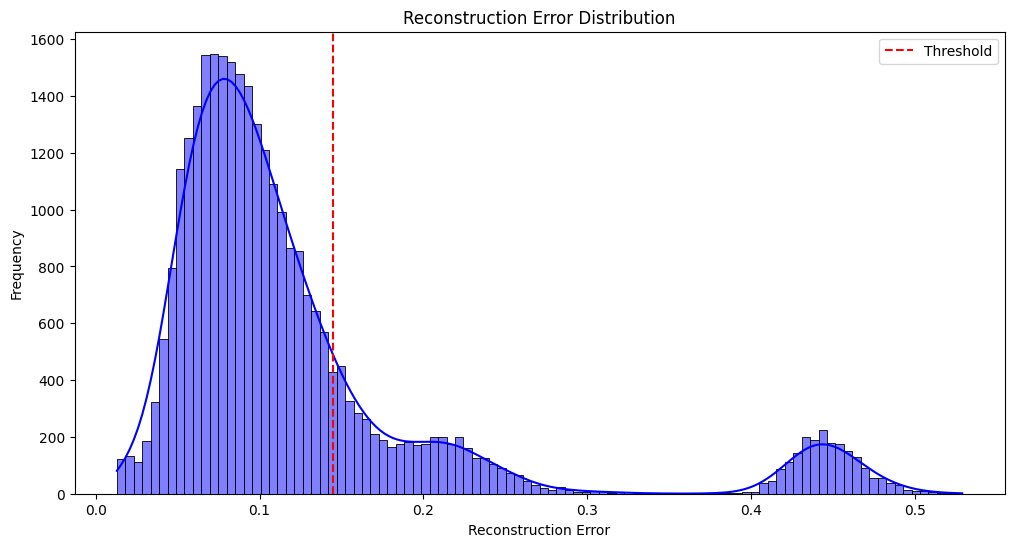

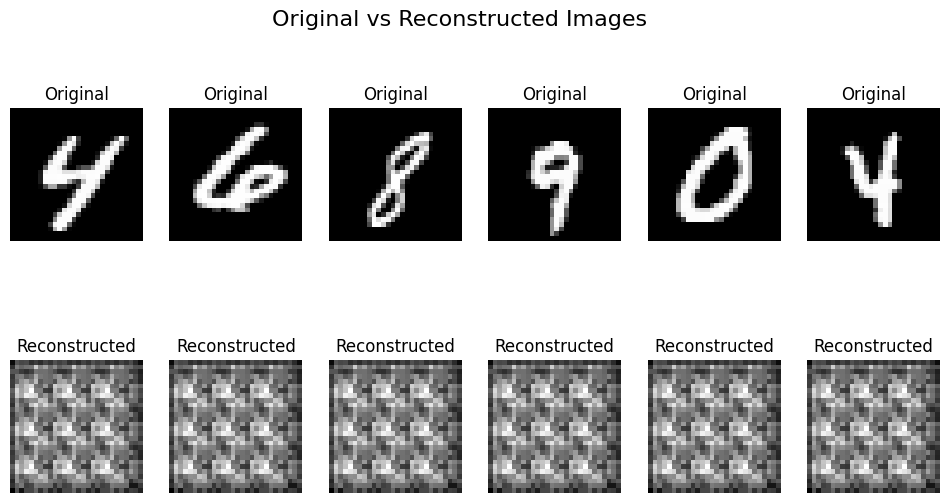

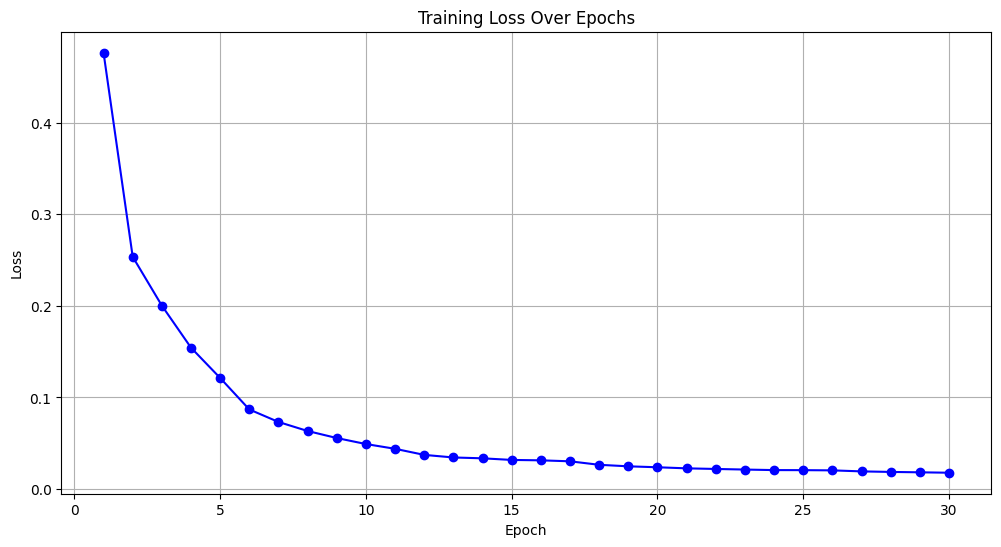

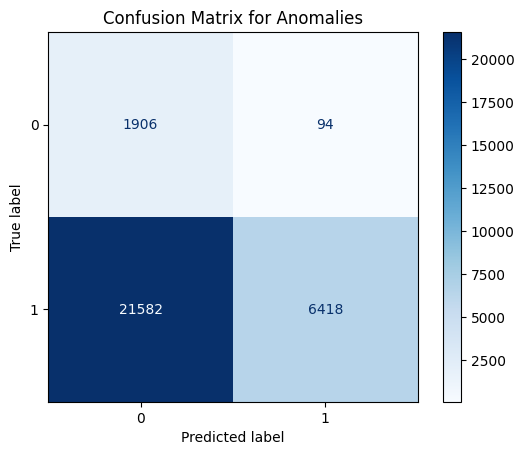

In [ ]:
# Evaluation
corruption_types = [
    'identity', 'shot_noise', 'impulse_noise', 'glass_blur', 'motion_blur',
    'shear', 'scale', 'rotate', 'brightness', 'translate', 'stripe',
    'fog', 'spatter', 'dotted_line', 'zigzag'
]

all_predictions = []
all_ground_truths = []
all_reconstruction_errors = []

total_test_images = 0

for corruption in corruption_types:
    print(f"Evaluating corruption type: {corruption}")
    ds_test, ds_info = tfds.load(
        f'mnist_corrupted/{corruption}',
        split='test[:2000]',
        as_supervised=True,
        with_info=True
    )

    test_images = convert_to_numpy(ds_test)
    test_images = torch.Tensor(test_images / 255.0).unsqueeze(1).squeeze(-1)
    test_loader = DataLoader(TensorDataset(test_images), batch_size=batch_size, shuffle=False)

    reconstruction_errors = reconstruction_loss(model, test_loader)
    all_reconstruction_errors.extend(reconstruction_errors)

    ground_truth = np.zeros_like(reconstruction_errors) if corruption == 'identity' else np.ones_like(reconstruction_errors)

    predictions = reconstruction_errors > threshold
    all_predictions.extend(predictions)
    all_ground_truths.extend(ground_truth)

    print(f"Number of images in the {corruption} test set: {len(test_images)}")
    total_test_images += len(test_images)

print(f"Total number of test images across all corruption types: {total_test_images}")

# Confusion matrix
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)
conf_matrix = confusion_matrix(all_ground_truths, all_predictions)

# Plotting of reconstruction errors
plt.figure(figsize=(12, 6))
plt.title('Reconstruction Error Distribution')
sns.histplot(all_reconstruction_errors, bins=100, kde=True, color='blue')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Original vs. reconstructed images
for images, in train_loader:
    images = images.to(device)
    z = torch.zeros(images.size(0), nz, 1, 1, device=device)
    reconstructed_images = model(z)
    break

plt.figure(figsize=(12, 6))
plt.suptitle('Original vs Reconstructed Images', fontsize=16)

for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.imshow(images[i].cpu().detach().squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

for i in range(6):
    plt.subplot(2, 6, i + 7)
    plt.imshow(reconstructed_images[i].cpu().detach().squeeze(), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.show()

# Training loss
plt.figure(figsize=(12, 6))
plt.title('Training Loss Over Epochs')
plt.plot(range(1, num_epochs + 1), training_losses, marker='o', linestyle='-', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

confusion_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
confusion_disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Anomalies')
plt.show()

### FOR 60K TRAIN SPLIT

In [1]:
import tensorflow_datasets as tfds
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Loading
(train_data, test_data), ds_info = tfds.load(
    'mnist_corrupted/identity',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)


def convert_to_numpy(dataset):
    return np.array([img.numpy() for img, _ in dataset])

train_images = convert_to_numpy(train_data)
test_images = convert_to_numpy(test_data)


train_images = torch.Tensor(train_images / 255.0).unsqueeze(1).squeeze(-1)
test_images = torch.Tensor(test_images / 255.0).unsqueeze(1).squeeze(-1)

# Create DataLoader
batch_size = 128
train_dataset = TensorDataset(train_images)
test_dataset = TensorDataset(test_images)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training set size: {len(train_images)}")
print(f"Test set size (identity): {len(test_images)}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/identity/incomplete.LWEBDR_1.0.0/mnist_corrupted-train.tfr…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/identity/incomplete.LWEBDR_1.0.0/mnist_corrupted-test.tfre…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/identity/1.0.0. Subsequent calls will reuse this data.
Training set size: 60000
Test set size (identity): 10000


In [2]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=True),
            nn.BatchNorm2d(ngf * 4),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 3, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 2),
            nn.ELU(),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf),
            nn.ELU(),
            nn.ConvTranspose2d(ngf, 1, 4, 2, 1, bias=True),
            nn.Tanh()
        )

    def forward(self, x):
        return self.network(x)

# Initialization
nz = 100
ngf = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Generator().to(device)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [3]:
# Training loop
num_epochs = 30
training_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_images, in train_loader:
        batch_images = batch_images.to(device)
        current_batch_size = batch_images.size(0)

        optimizer.zero_grad()

        # Gradient origin optimization
        z = torch.zeros(current_batch_size, nz, 1, 1, device=device, requires_grad=True)
        g = model(z)
        L_inner = ((g - batch_images) ** 2).sum(1).mean()
        grad = torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]
        z = -grad

        # Optimizing data fitting loss
        g = model(z)
        L_outer = ((g - batch_images) ** 2).sum(1).mean()
        L_outer.backward()
        optimizer.step()

        epoch_loss += L_outer.item() * current_batch_size

    average_epoch_loss = epoch_loss / len(train_loader.dataset)
    training_losses.append(average_epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_epoch_loss:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/30], Loss: 0.0607
Epoch [2/30], Loss: 0.0122
Epoch [3/30], Loss: 0.0086
Epoch [4/30], Loss: 0.0067
Epoch [5/30], Loss: 0.0053
Epoch [6/30], Loss: 0.0045
Epoch [7/30], Loss: 0.0039
Epoch [8/30], Loss: 0.0035
Epoch [9/30], Loss: 0.0031
Epoch [10/30], Loss: 0.0029
Epoch [11/30], Loss: 0.0027
Epoch [12/30], Loss: 0.0025
Epoch [13/30], Loss: 0.0024
Epoch [14/30], Loss: 0.0023
Epoch [15/30], Loss: 0.0022
Epoch [16/30], Loss: 0.0022
Epoch [17/30], Loss: 0.0021
Epoch [18/30], Loss: 0.0021
Epoch [19/30], Loss: 0.0020
Epoch [20/30], Loss: 0.0020
Epoch [21/30], Loss: 0.0019
Epoch [22/30], Loss: 0.0019
Epoch [23/30], Loss: 0.0018
Epoch [24/30], Loss: 0.0018
Epoch [25/30], Loss: 0.0017
Epoch [26/30], Loss: 0.0017
Epoch [27/30], Loss: 0.0017
Epoch [28/30], Loss: 0.0017
Epoch [29/30], Loss: 0.0017
Epoch [30/30], Loss: 0.0016


In [4]:
# Computation of reconstruction errors
def reconstruction_loss(model, loader):
    model.eval()
    error_list = []
    with torch.no_grad():
        for batch_images, in loader:
            batch_images = batch_images.to(device)
            current_batch_size = batch_images.size(0)
            z = torch.zeros(current_batch_size, nz, 1, 1, device=device)
            generated_images = model(z)
            loss = torch.mean((generated_images - batch_images) ** 2, dim=[1, 2, 3])
            error_list.extend(loss.cpu().numpy())
    return np.array(error_list)

training_reconstruction_errors = reconstruction_loss(model, train_loader)

# Calculation of dynamic threshold
def dynamic_threshold(errors):
    return np.mean(errors) + 2 * np.std(errors)

# Setting the anomaly detection threshold
threshold = dynamic_threshold(training_reconstruction_errors)
print(f"Initial anomaly detection threshold: {threshold}")

Initial anomaly detection threshold: 0.18726957589387894


Evaluating corruption type: identity
Number of images in the identity test set: 2000
Evaluating corruption type: shot_noise


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/shot_noise/incomplete.6IW2JD_1.0.0/mnist_corrupted-train.t…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/shot_noise/incomplete.6IW2JD_1.0.0/mnist_corrupted-test.tf…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/shot_noise/1.0.0. Subsequent calls will reuse this data.
Number of images in the shot_noise test set: 2000
Evaluating corruption type: impulse_noise


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/impulse_noise/incomplete.HZFDJI_1.0.0/mnist_corrupted-trai…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/impulse_noise/incomplete.HZFDJI_1.0.0/mnist_corrupted-test…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/impulse_noise/1.0.0. Subsequent calls will reuse this data.
Number of images in the impulse_noise test set: 2000
Evaluating corruption type: glass_blur


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/glass_blur/incomplete.PTEPPQ_1.0.0/mnist_corrupted-train.t…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/glass_blur/incomplete.PTEPPQ_1.0.0/mnist_corrupted-test.tf…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/glass_blur/1.0.0. Subsequent calls will reuse this data.
Number of images in the glass_blur test set: 2000
Evaluating corruption type: motion_blur


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/motion_blur/incomplete.V7P7A4_1.0.0/mnist_corrupted-train.…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/motion_blur/incomplete.V7P7A4_1.0.0/mnist_corrupted-test.t…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/motion_blur/1.0.0. Subsequent calls will reuse this data.
Number of images in the motion_blur test set: 2000
Evaluating corruption type: shear


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/shear/incomplete.ZMO07G_1.0.0/mnist_corrupted-train.tfreco…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/shear/incomplete.ZMO07G_1.0.0/mnist_corrupted-test.tfrecor…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/shear/1.0.0. Subsequent calls will reuse this data.
Number of images in the shear test set: 2000
Evaluating corruption type: scale


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/scale/incomplete.K59F95_1.0.0/mnist_corrupted-train.tfreco…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/scale/incomplete.K59F95_1.0.0/mnist_corrupted-test.tfrecor…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/scale/1.0.0. Subsequent calls will reuse this data.
Number of images in the scale test set: 2000
Evaluating corruption type: rotate


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/rotate/incomplete.BZYYPT_1.0.0/mnist_corrupted-train.tfrec…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/rotate/incomplete.BZYYPT_1.0.0/mnist_corrupted-test.tfreco…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/rotate/1.0.0. Subsequent calls will reuse this data.
Number of images in the rotate test set: 2000
Evaluating corruption type: brightness


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/brightness/incomplete.O1YG3U_1.0.0/mnist_corrupted-train.t…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/brightness/incomplete.O1YG3U_1.0.0/mnist_corrupted-test.tf…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/brightness/1.0.0. Subsequent calls will reuse this data.
Number of images in the brightness test set: 2000
Evaluating corruption type: translate


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/translate/incomplete.9IN5KI_1.0.0/mnist_corrupted-train.tf…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/translate/incomplete.9IN5KI_1.0.0/mnist_corrupted-test.tfr…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/translate/1.0.0. Subsequent calls will reuse this data.
Number of images in the translate test set: 2000
Evaluating corruption type: stripe


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/stripe/incomplete.U80FS4_1.0.0/mnist_corrupted-train.tfrec…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/stripe/incomplete.U80FS4_1.0.0/mnist_corrupted-test.tfreco…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/stripe/1.0.0. Subsequent calls will reuse this data.
Number of images in the stripe test set: 2000
Evaluating corruption type: fog


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/fog/incomplete.VCYAB3_1.0.0/mnist_corrupted-train.tfrecord…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/fog/incomplete.VCYAB3_1.0.0/mnist_corrupted-test.tfrecord*…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/fog/1.0.0. Subsequent calls will reuse this data.
Number of images in the fog test set: 2000
Evaluating corruption type: spatter


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/spatter/incomplete.90RR5O_1.0.0/mnist_corrupted-train.tfre…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/spatter/incomplete.90RR5O_1.0.0/mnist_corrupted-test.tfrec…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/spatter/1.0.0. Subsequent calls will reuse this data.
Number of images in the spatter test set: 2000
Evaluating corruption type: dotted_line


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/dotted_line/incomplete.5VRDZQ_1.0.0/mnist_corrupted-train.…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/dotted_line/incomplete.5VRDZQ_1.0.0/mnist_corrupted-test.t…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/dotted_line/1.0.0. Subsequent calls will reuse this data.
Number of images in the dotted_line test set: 2000
Evaluating corruption type: zigzag


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/zigzag/incomplete.9XNMAX_1.0.0/mnist_corrupted-train.tfrec…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/zigzag/incomplete.9XNMAX_1.0.0/mnist_corrupted-test.tfreco…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/zigzag/1.0.0. Subsequent calls will reuse this data.
Number of images in the zigzag test set: 2000
Total number of test images across all corruption types: 30000


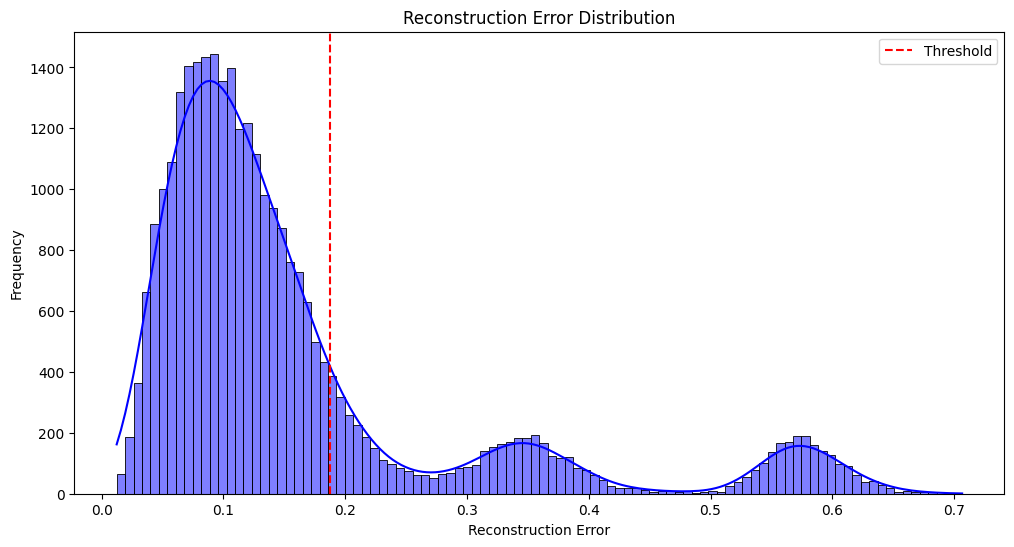

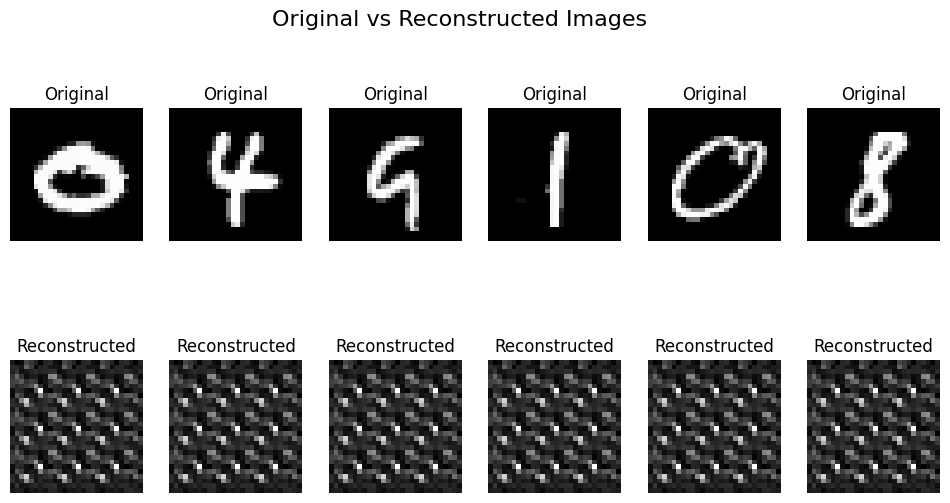

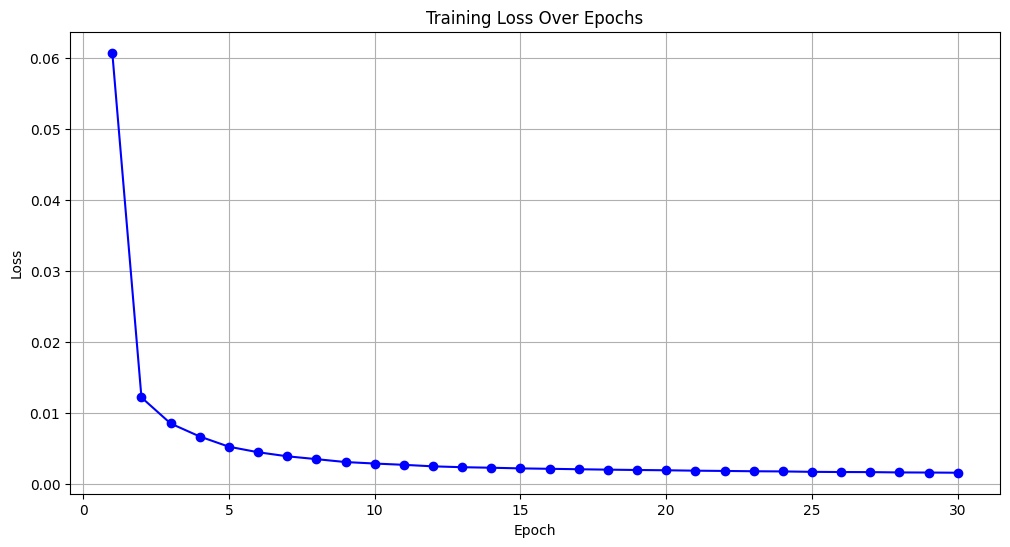

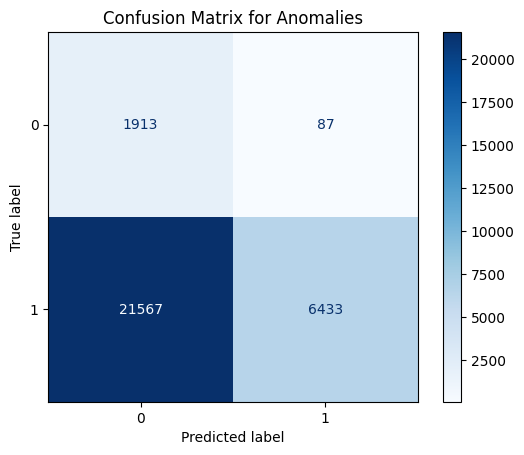

In [5]:
# Evaluation
corruption_types = [
    'identity', 'shot_noise', 'impulse_noise', 'glass_blur', 'motion_blur',
    'shear', 'scale', 'rotate', 'brightness', 'translate', 'stripe',
    'fog', 'spatter', 'dotted_line', 'zigzag'
]

all_predictions = []
all_ground_truths = []
all_reconstruction_errors = []

total_test_images = 0

for corruption in corruption_types:
    print(f"Evaluating corruption type: {corruption}")
    ds_test, ds_info = tfds.load(
        f'mnist_corrupted/{corruption}',
        split='test[:2000]',
        as_supervised=True,
        with_info=True
    )

    test_images = convert_to_numpy(ds_test)
    test_images = torch.Tensor(test_images / 255.0).unsqueeze(1).squeeze(-1)
    test_loader = DataLoader(TensorDataset(test_images), batch_size=batch_size, shuffle=False)

    reconstruction_errors = reconstruction_loss(model, test_loader)
    all_reconstruction_errors.extend(reconstruction_errors)

    ground_truth = np.zeros_like(reconstruction_errors) if corruption == 'identity' else np.ones_like(reconstruction_errors)

    predictions = reconstruction_errors > threshold
    all_predictions.extend(predictions)
    all_ground_truths.extend(ground_truth)

    print(f"Number of images in the {corruption} test set: {len(test_images)}")
    total_test_images += len(test_images)

print(f"Total number of test images across all corruption types: {total_test_images}")

# Confusion matrix
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)
conf_matrix = confusion_matrix(all_ground_truths, all_predictions)

# Plotting of reconstruction errors
plt.figure(figsize=(12, 6))
plt.title('Reconstruction Error Distribution')
sns.histplot(all_reconstruction_errors, bins=100, kde=True, color='blue')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Original vs. reconstructed images
for images, in train_loader:
    images = images.to(device)
    z = torch.zeros(images.size(0), nz, 1, 1, device=device)
    reconstructed_images = model(z)
    break

plt.figure(figsize=(12, 6))
plt.suptitle('Original vs Reconstructed Images', fontsize=16)

for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.imshow(images[i].cpu().detach().squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

for i in range(6):
    plt.subplot(2, 6, i + 7)
    plt.imshow(reconstructed_images[i].cpu().detach().squeeze(), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.show()

# Training loss
plt.figure(figsize=(12, 6))
plt.title('Training Loss Over Epochs')
plt.plot(range(1, num_epochs + 1), training_losses, marker='o', linestyle='-', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

confusion_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
confusion_disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Anomalies')
plt.show()